<a href="https://colab.research.google.com/github/Khaled-Mohammed-Abdelgaber/deep-learning-projects-/blob/main/master_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import *
import pandas as pd

In [2]:
#first to mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np

#Data preparation

In [5]:
ECG1 = pd.read_csv("/content/drive/MyDrive/data/peak2peak_aug_2022/Part_1/10_beat_signals/part_1_ECG_signals_10_beats_Aug_2022.csv")
PPG1 = pd.read_csv("/content/drive/MyDrive/data/peak2peak_aug_2022/Part_1/10_beat_signals/part_1_PPG_signals_10_beats_Aug_2022.csv")

PPG2 = pd.read_csv("/content/drive/MyDrive/data/peak2peak_aug_2022/Part_2/10_beat_signals/part_2_PPG_signals_10_beats_Aug_2022.csv")
ECG2= pd.read_csv("/content/drive/MyDrive/data/peak2peak_aug_2022/Part_2/10_beat_signals/part_2_ECG_signals_10_beats_Aug_2022.csv")

In [6]:
PPG = pd.concat([PPG1 , PPG2])

In [7]:
ECG = pd.concat([ECG1 , ECG2])

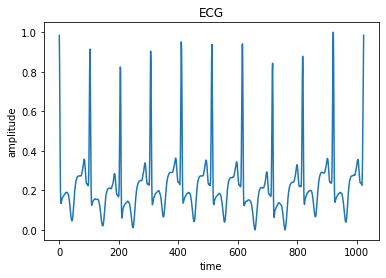

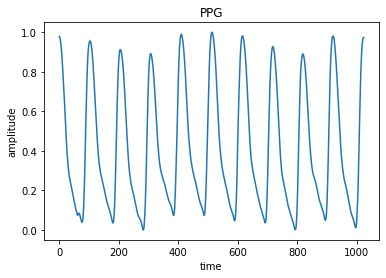

In [9]:
plt.plot(ECG.iloc[0,:].values);
plt.xlabel('time');
plt.ylabel('amplitude');
plt.title("ECG");

plt.figure();
plt.plot(PPG.iloc[0,:].values);
plt.xlabel('time');
plt.ylabel('amplitude');
plt.title("PPG");

In [10]:
X = PPG.values
input_shape = (X.shape[0],1024,1)
X = np.reshape(X,input_shape)
print("input shape is ",X.shape)
y= ECG.values
input_shape = (y.shape[0],1024,1)
y = np.reshape(y,input_shape)
print("output shape is ",y.shape)

input shape is  (30906, 1024, 1)
output shape is  (30906, 1024, 1)


In [11]:
X_train,X_test , y_train  , y_test = train_test_split(X , y , test_size = 0.11,shuffle=True)
print("train shape is ",X_train.shape)
print("test shape is ",X_test.shape)

train shape is  (27506, 1024, 1)
test shape is  (3400, 1024, 1)


#creating sampling layer

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#Building Encoder Model

In [12]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(1024, 1))
x = Conv1D(256, 5, activation="relu", padding="same")(encoder_inputs)
x = MaxPooling1D(2, padding='same')(x)

x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)

x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)

x = Conv1D(32,3, activation='relu', padding='same')(x)
x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 256)    1536        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 512, 256)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 512, 128)     163968      ['max_pooling1d[0][0]']          
                                                                                            

#Building Decoder Model

In [14]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(128 * 32, activation="relu")(latent_inputs)
x = Reshape((128,32))(x)

x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(256, 5, activation='relu', padding='same')(x)
#x = UpSampling1D(2)(x)
decoder_outputs = Conv1D(1, 5, activation='relu', padding='same')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              266240    
                                                                 
 reshape_1 (Reshape)         (None, 128, 32)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 128, 32)           3104      
                                                                 
 up_sampling1d_4 (UpSampling  (None, 256, 32)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 256, 64)           6208      
                                                           

#Training

In [26]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, )
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    

In [28]:
callbacks = [
            keras.callbacks.TensorBoard(
            log_dir='my_log_dir',
            histogram_freq=1,
            embeddings_freq=1,
            ),
             ModelCheckpoint('/content/drive/MyDrive/Master/traditional autoecoder',
                             save_best_only=True),
             keras.callbacks.EarlyStopping(
                                      monitor="val_loss",
                                      min_delta= 0,
                                      patience= 5,
                                      verbose= 0,
                                      mode="auto",
                                      baseline=None,
                                      restore_best_weights=True,
)
]

In [30]:
vae = VAE(encoder, decoder)
vae.summary()

Model: "vae_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 64),              720736    
                              (None, 64),                        
                              (None, 64)]                        
                                                                 
 decoder (Functional)        (None, 1024, 1)           482017    
                                                                 
Total params: 1,202,759
Trainable params: 1,202,753
Non-trainable params: 6
_________________________________________________________________


In [31]:
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X_train , y_train, epochs=100, batch_size=128,validation_split= 0.15,callbacks = callbacks)

Epoch 1/100
183/183 [==============================] - ETA: 0s - loss: 541.5668 - reconstruction_loss: 536.3147 - kl_loss: 1.5543

NotImplementedError: ignored